In [1]:
!pip install umap-learn

     |████████████████████████████████| 86 kB 2.7 MB/s 
     |████████████████████████████████| 1.1 MB 13.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=0ed3c27ad6545b5b825ee6172be860d4cc539b28449e08d687253f2ec8275ddb
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=91aea6ae43a61cc0b4d39b42b684a5121c95a44a85f5926c7339ce9affbc446d
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [2]:
import umap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from sklearn import preprocessing
import sklearn.neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score

from scipy.spatial.distance import cdist

import xgboost as xgb
from xgboost import plot_tree
from xgboost import cv

import tensorflow as tf

In [3]:
df = {}
df['train'] = pd.read_csv('train.csv')

In [4]:
df['train'] = df['train'].drop(df['train'].loc[df['train']['y'] > 150].index)

In [5]:
df['train']

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8405,107.39,ak,s,as,c,d,aa,d,q,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4205,8406,108.77,j,o,t,d,d,aa,h,h,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4206,8412,109.22,ak,v,r,a,d,aa,g,e,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4207,8415,87.48,al,r,e,f,d,aa,l,u,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [6]:
def catEncode(dataframe):
  for x in dataframe:
    encoder = preprocessing.LabelEncoder()
    dataframe[x] = encoder.fit_transform(dataframe[x])
  return dataframe

In [7]:
def UMAP_test(data, n_neighbors, **args):
  reducer = umap.UMAP(n_neighbors= n_neighbors, **args)
  scaler = StandardScaler()

  enscaled = scaler.fit_transform(data)
  embedding = reducer.fit_transform(enscaled)

  e_df = pd.DataFrame(embedding)
  e_df['y'] = df['train']['y']
  
  return e_df

In [8]:
def plot_UMAP(dataframe, plot_kde=False):
  plt.figure(figsize=(30,30))
  if plot_kde:
    sns.kdeplot(data=dataframe, x=0, y=1, cmap = 'vlag', fill=True)
  else:
    vmin = df['train']['y'].min()
    vcenter = df['train']['y'].mean()
    vmax = 150
    # norm = plt.Normalize(0,150)
    divnorm = mpl.colors.TwoSlopeNorm(vmin=0, vcenter=1.5, vmax=150)
    cpal = sns.color_palette("Spectral", as_cmap=True)
    sns.scatterplot(data=dataframe, x=0, y=1, hue='y', palette=cpal, alpha=1)
  plt.show() 

In [9]:
def outliersY(data, contamination):
  outlier_scores = sklearn.neighbors.LocalOutlierFactor(contamination=contamination).fit_predict(data.to_numpy())
  outlierdf = pd.DataFrame(outlier_scores)
  outlierdf['y'] = df['train']['y']
  outlierdf['id'] = df['train']['ID']

  sns.scatterplot(data=outlierdf, x='id', y='y', hue=0, cmap='Reds')
  plt.show()


  training_data = outlierdf.drop(outlierdf[0].loc[outlierdf[0] < 1].index)
  training_data = training_data.drop('y',axis=1).merge(df['train'],left_on='id',right_on='ID')
  trainVals = training_data.drop(['id',0,'y'],axis=1)
  trainVals = catEncode(trainVals)
  
  trainY = training_data['y']
  
  return trainVals, trainY

In [ ]:
plt.figure(dpi=400)
flierprops = dict(marker='o', markerfacecolor=(0.50,0.50,0.50,0.50), markeredgewidth=0.5,markersize=5,  markeredgecolor='black')
sns.boxplot(x = df['train']['y'],linewidth=0.5,flierprops=flierprops)

In [14]:
catencoded = catEncode(df['train'].select_dtypes(include='object'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [94]:
def createEmbeddingModel(catDF, summary=False):
  models = []
  inputs = []

  for cat in catDF.columns:
    vocab_size = catDF[cat].nunique()
  
    input = tf.keras.layers.Input(shape=(1,),name='input_' + '_'.join(cat.split(' ')))
    inputs.append(input)

    embed = tf.keras.layers.Embedding(vocab_size, min(50,vocab_size//2+1),trainable=True,embeddings_initializer=tf.initializers.random_normal)(input)
    embed_reshaped = tf.keras.layers.Reshape(target_shape=(min(50,vocab_size//2+1),))(embed)
    models.append(embed_reshaped)

  merged_models= tf.keras.layers.concatenate(models)

  pre_preds = tf.keras.layers.Dense(1005,kernel_regularizer = 
                                      tf.keras.regularizers.L1L2(l1=10, l2=10)
                                      )(merged_models)
  pre_preds = tf.keras.layers.BatchNormalization()(pre_preds)
  pre_preds = tf.keras.layers.Dropout(0.9,seed=1997)(pre_preds)
  pre_preds = tf.keras.layers.GaussianNoise(0.15)(pre_preds)
  pre_preds = tf.keras.layers.Activation('relu')(pre_preds)

  pre_preds = tf.keras.layers.Dense(1005,kernel_regularizer = 
                                      tf.keras.regularizers.L1L2(l1=10, l2=10)
                                      )(pre_preds)
  pre_preds = tf.keras.layers.BatchNormalization()(pre_preds)
  pre_preds = tf.keras.layers.Dropout(0.9,seed=1997)(pre_preds)
  pre_preds = tf.keras.layers.GaussianNoise(0.15)(pre_preds)
  pre_preds = tf.keras.layers.Activation('relu')(pre_preds)

  pred = tf.keras.layers.Dense(1,activation='relu')(pre_preds)
  model_full = tf.keras.models.Model(inputs= inputs, outputs =pred)
  model_full.compile(loss='mean_squared_error', metrics=['mean_absolute_error'], 
                      optimizer=tf.keras.optimizers.Adam(
                        learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
                        name='Adam'))
    
  if summary:
    model_full.summary()

  return model_full

In [95]:
# def trainModel(catDF, target):
nxtrain, nxval, nytrain, nyval = train_test_split(catencoded,df['train']['y'], test_size=0.2, random_state=None)

train_input= {
    "input_X0":nxtrain["X0"],
    "input_X1":nxtrain["X1"],
    "input_X2":nxtrain["X2"],
    "input_X3":nxtrain["X3"],
    "input_X4":nxtrain["X4"],
    "input_X5":nxtrain["X5"],
    "input_X6":nxtrain["X6"],
    "input_X8":nxtrain["X8"]}
test_input={
    "input_X0":nxval["X0"],
    "input_X1":nxval["X1"],
    "input_X2":nxval["X2"],
    "input_X3":nxval["X3"],
    "input_X4":nxval["X4"],
    "input_X5":nxval["X5"],
    "input_X6":nxval["X6"],
    "input_X8":nxval["X8"]}

In [96]:
testmodel = createEmbeddingModel(catencoded, summary=True)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_X0 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_X1 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_X2 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_X3 (InputLayer)          [(None, 1)]          0           []                               
                                                                                           

In [97]:
import os
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

estopping = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=20, restore_best_weights=True)
mchecks = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  monitor='val_mean_absolute_error',
                                                  mode='max',
                                                  save_best_only=True)

preds = testmodel.fit(train_input,nytrain,epochs=450,batch_size=22, 
                       verbose = True, callbacks=[estopping, mchecks], 
                       validation_data=(test_input,nyval))

Epoch 1/450
153/153 [==============================] - 7s 30ms/step - loss: 61323.8320 - mean_absolute_error: 56.5804 - val_loss: 17766.7871 - val_mean_absolute_error: 96.6181
Epoch 2/450
153/153 [==============================] - 4s 29ms/step - loss: 7470.5146 - mean_absolute_error: 15.9349 - val_loss: 15103.6016 - val_mean_absolute_error: 90.5210
Epoch 3/450
153/153 [==============================] - 5s 36ms/step - loss: 7524.8223 - mean_absolute_error: 14.4315 - val_loss: 14693.4141 - val_mean_absolute_error: 85.1334
Epoch 4/450
153/153 [==============================] - 6s 40ms/step - loss: 7900.4351 - mean_absolute_error: 13.6487 - val_loss: 14356.6094 - val_mean_absolute_error: 79.9894
Epoch 5/450
153/153 [==============================] - 6s 39ms/step - loss: 8060.1436 - mean_absolute_error: 13.3851 - val_loss: 12295.0635 - val_mean_absolute_error: 66.8627
Epoch 6/450
153/153 [==============================] - 6s 43ms/step - loss: 8361.8623 - mean_absolute_error: 13.6604 - val_l

In [98]:
testmodel.evaluate(test_input,nyval,batch_size=22)

39/39 [==============================] - 0s 7ms/step - loss: 3335.9160 - mean_absolute_error: 6.4125


[3335.916015625, 6.412486553192139]

In [99]:
model = createEmbeddingModel(catencoded)
model.evaluate(train_input, nytrain, batch_size=22)

153/153 [==============================] - 2s 7ms/step - loss: 336154.1250 - mean_absolute_error: 100.3947


[336154.125, 100.39466094970703]

In [100]:
model = createEmbeddingModel(catencoded)
model.load_weights(checkpoint_path)
model.evaluate(train_input, nytrain, batch_size=22)

153/153 [==============================] - 2s 7ms/step - loss: 17729.8320 - mean_absolute_error: 96.4109


[17729.83203125, 96.41093444824219]

In [105]:
embeddings = ['embedding_82', 'embedding_83','embedding_84','embedding_85','embedding_86',
              'embedding_87','embedding_88','embedding_89']

In [102]:
def sumVectors(model, data, embeddings):
  column = {}
  for i,e in enumerate(data.columns):
    column[e] = {}
    for index,element in enumerate(data[e].unique()):
      column[e][element] = model.get_layer(embeddings[i]).get_weights()[0][index].sum()
    
  vectorized = pd.DataFrame()
  for x in column.keys():
    vectorized[x] = data[x].map(column[x])
  return vectorized

In [103]:
def colVectors(model, data, embeddings):
  weights = {}
  for index, x in enumerate(data.columns):
    weights[x] = {}
    for id, val in enumerate(data[x].unique()):
      weights[x][val] = {}
      for weightid, weightval in enumerate(model.get_layer(embeddings[index]).get_weights()[0][id]):
        weights[x][val][weightid] = weightval
  
  mappedembeddings = pd.DataFrame()
  encodedindex = []
  for row in data.iterrows():
    encodedindex.append(row[0])
    df0 = pd.DataFrame()
    for k, v in row[1].to_dict().items():
      names = []
      for z in weights[k][v].keys():
        names.append(str(k)+'_'+str(z))

      tempdf = pd.DataFrame([weights[k][v]])
      tempdf.columns = names
      df0 = pd.concat([df0,tempdf],axis=1)

    mappedembeddings = pd.concat([mappedembeddings,df0],axis=0)
  
  mappedembeddings.index = encodedindex
  return mappedembeddings

In [106]:
sumvec = sumVectors(testmodel, catencoded, embeddings)

In [107]:
colvec = colVectors(testmodel, catencoded, embeddings)

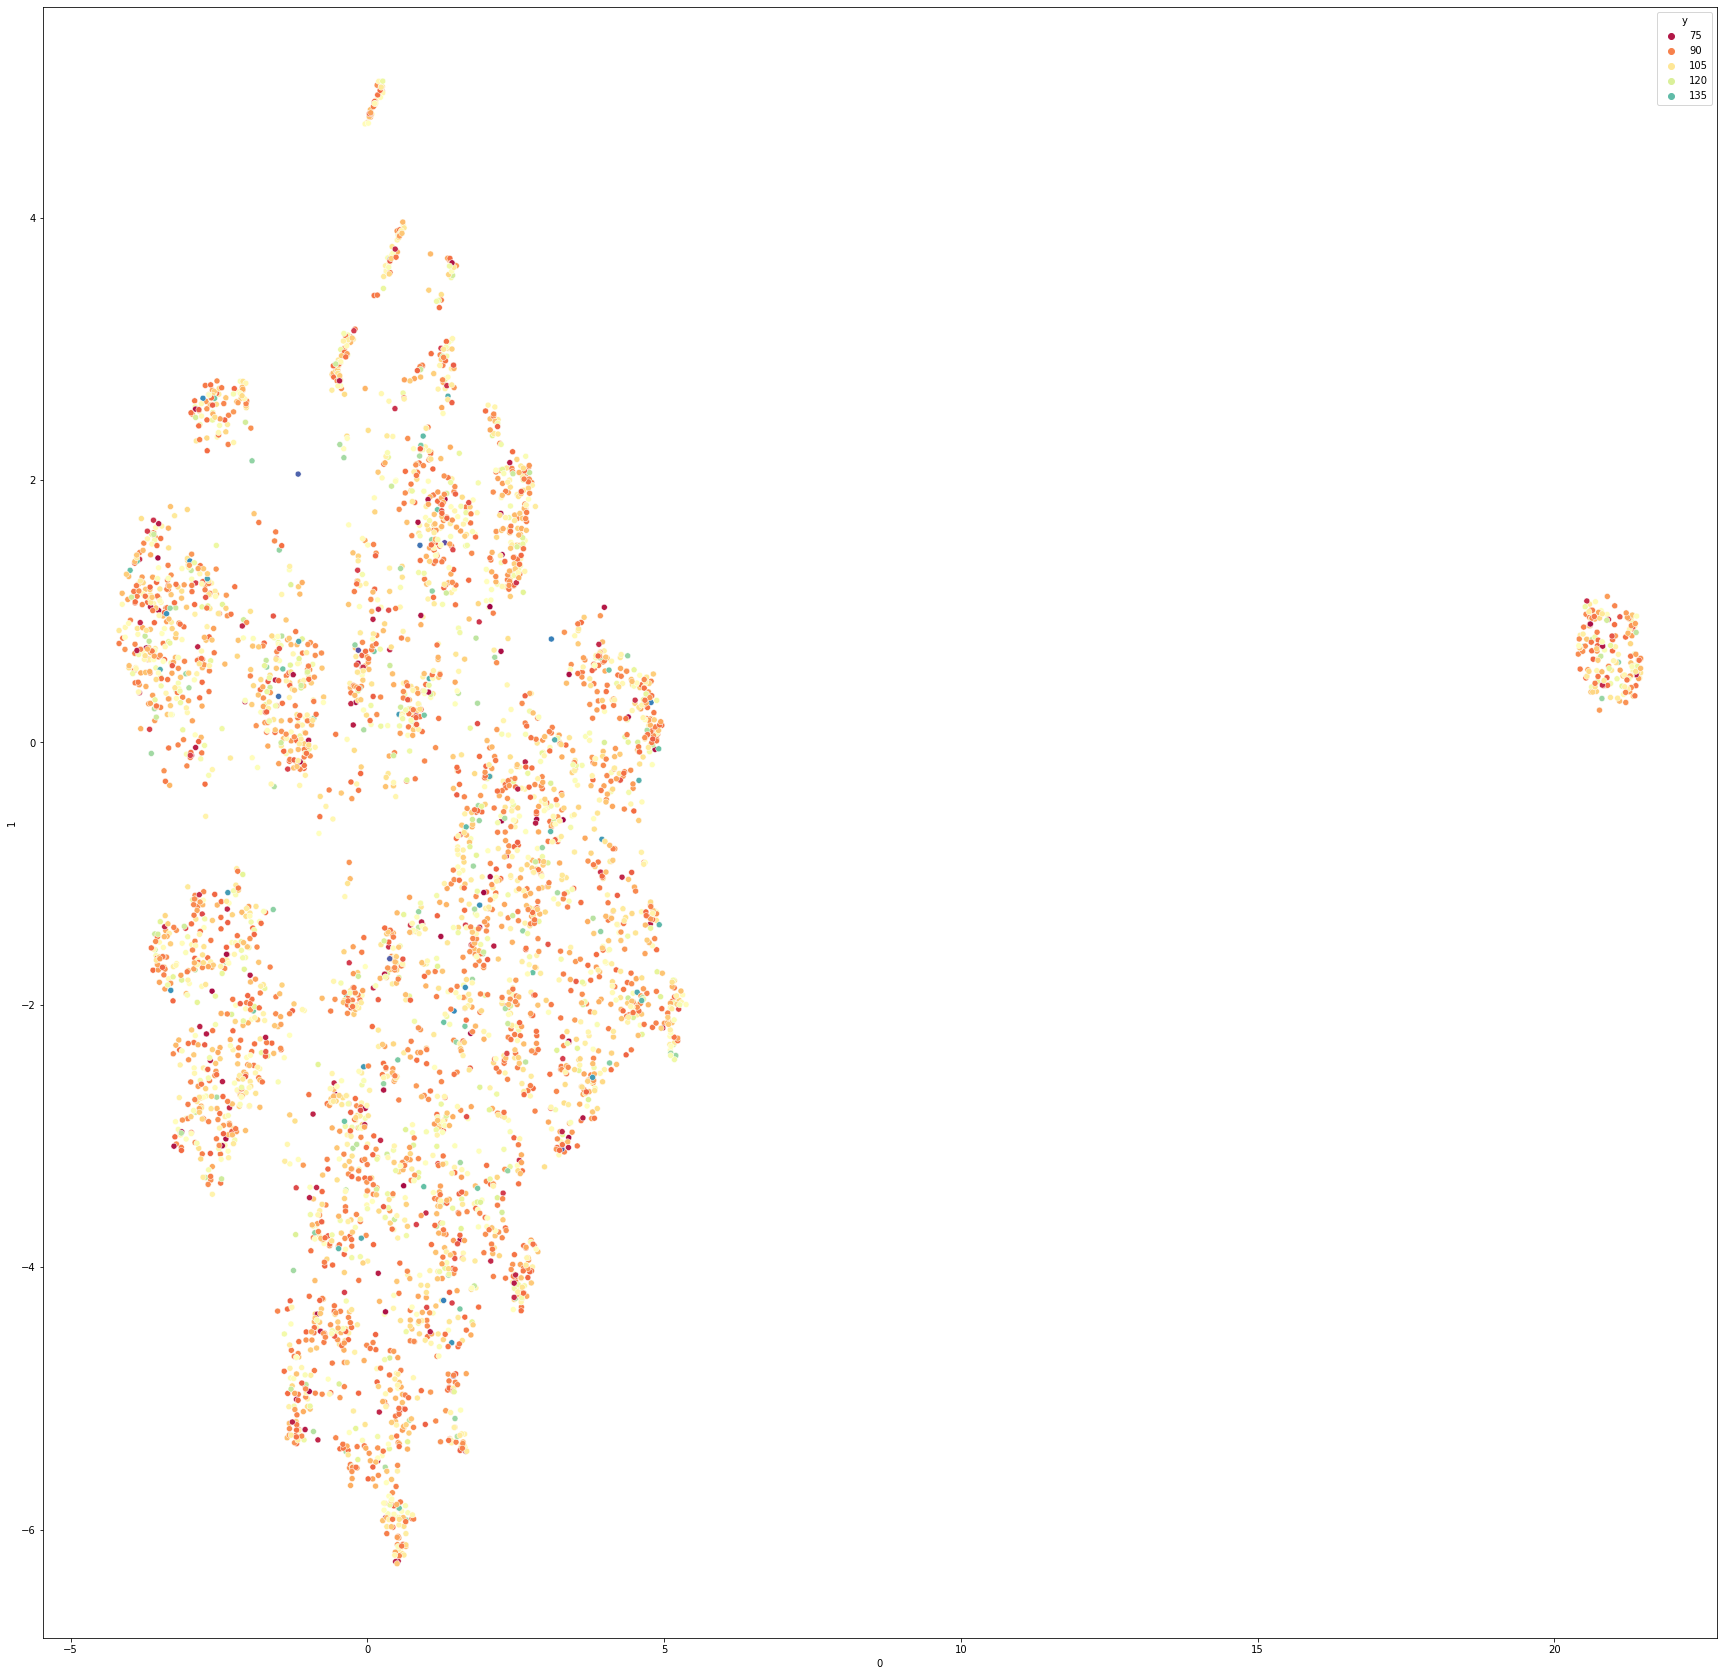

In [111]:
plot_UMAP(UMAP_test(sumvec, 900, min_dist=0.3))

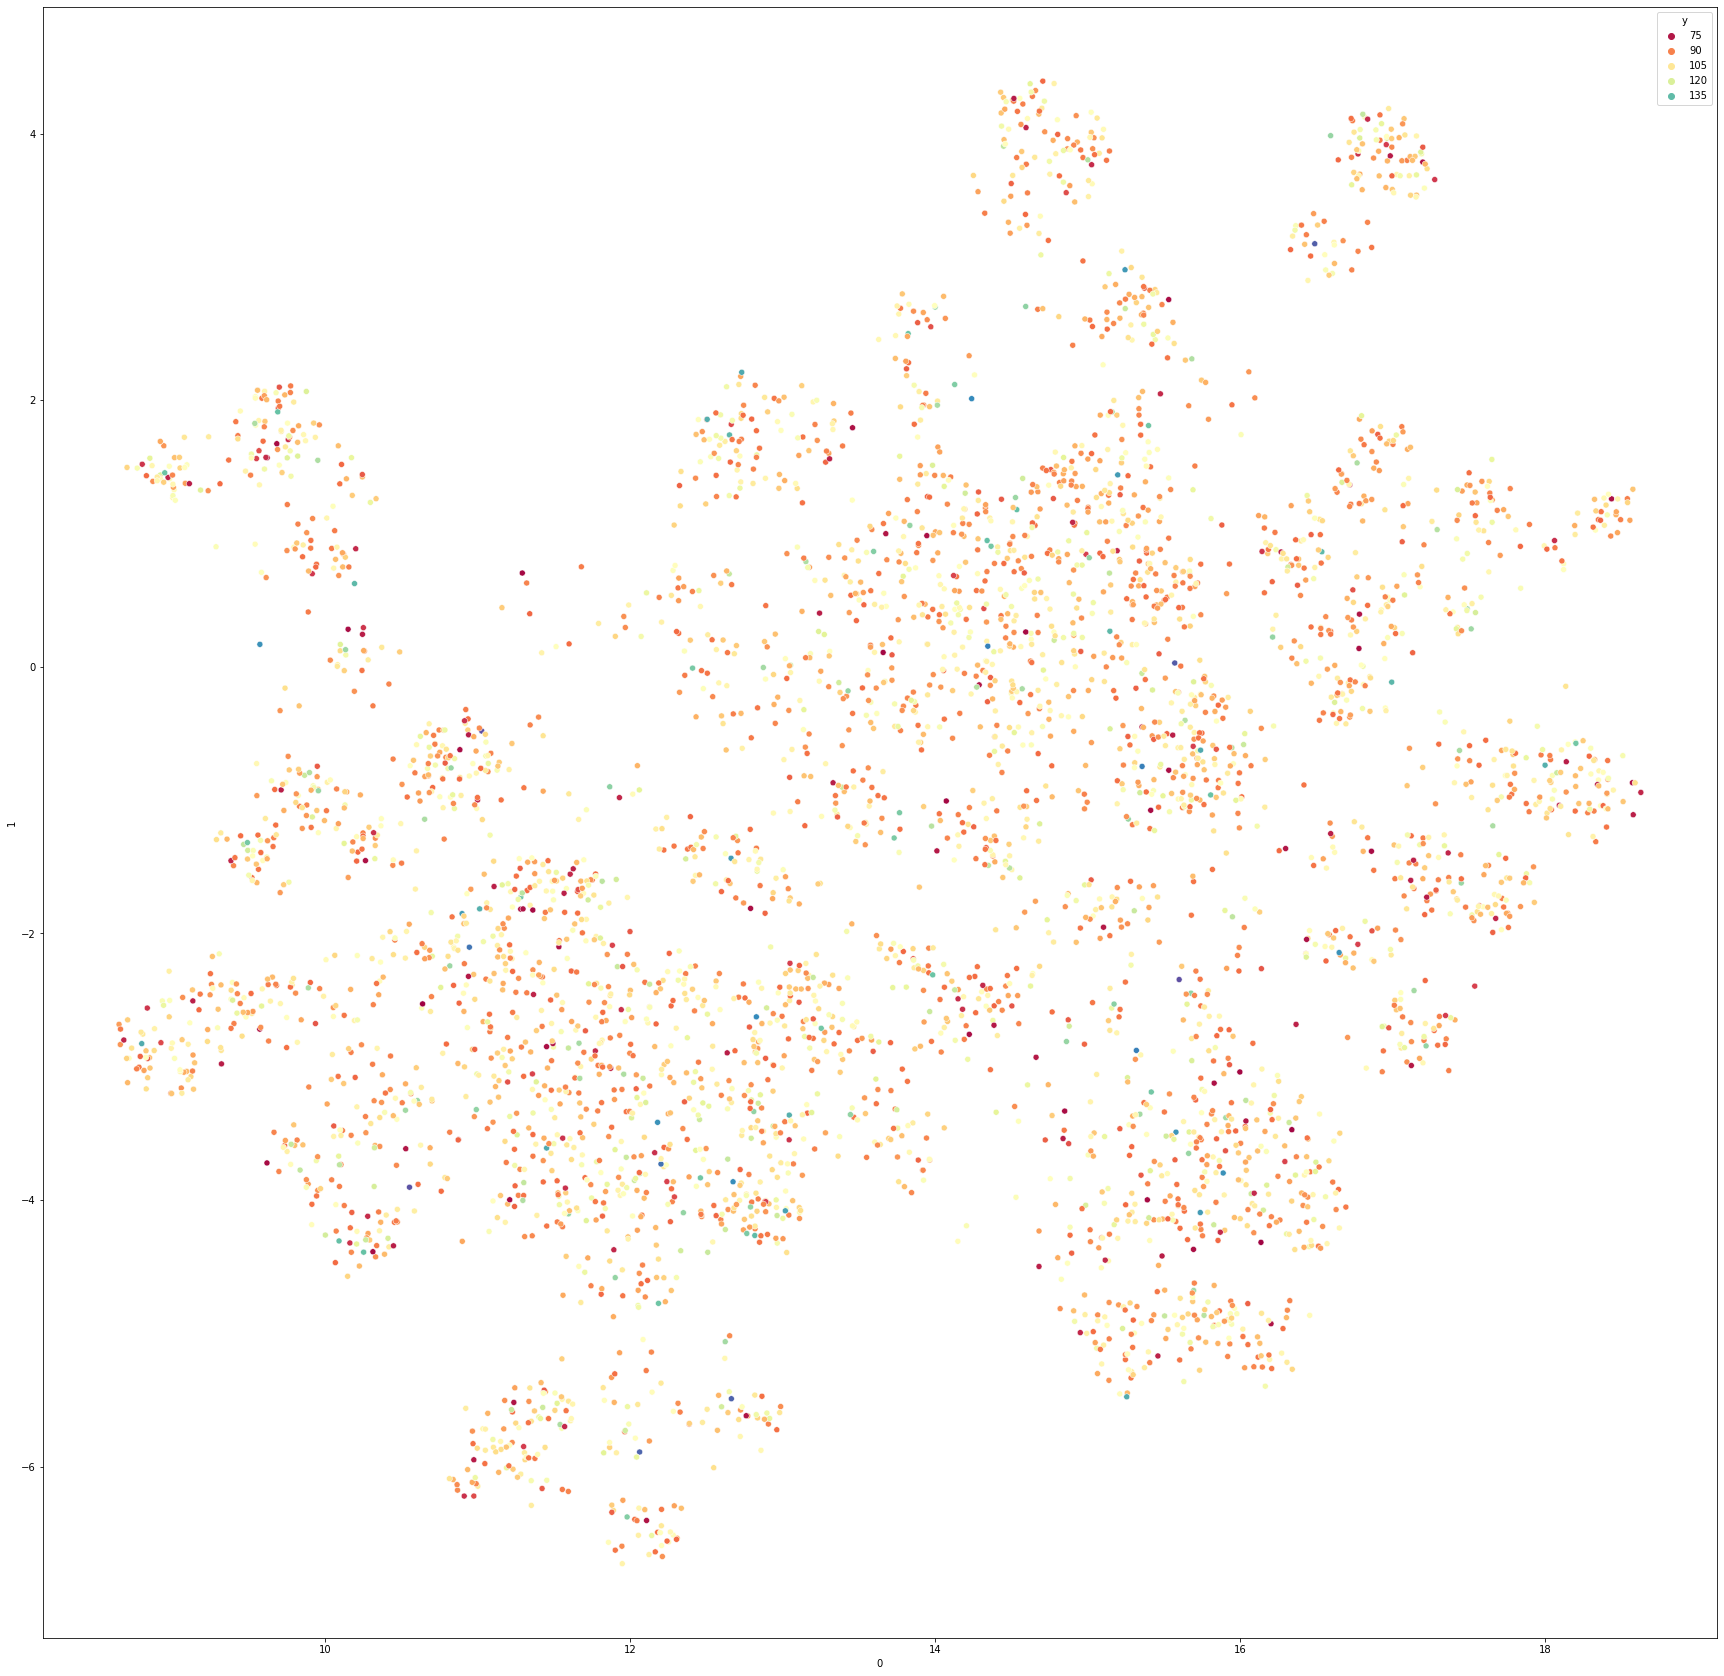

In [109]:
plot_UMAP(UMAP_test(colvec, 505, min_dist=0.5))

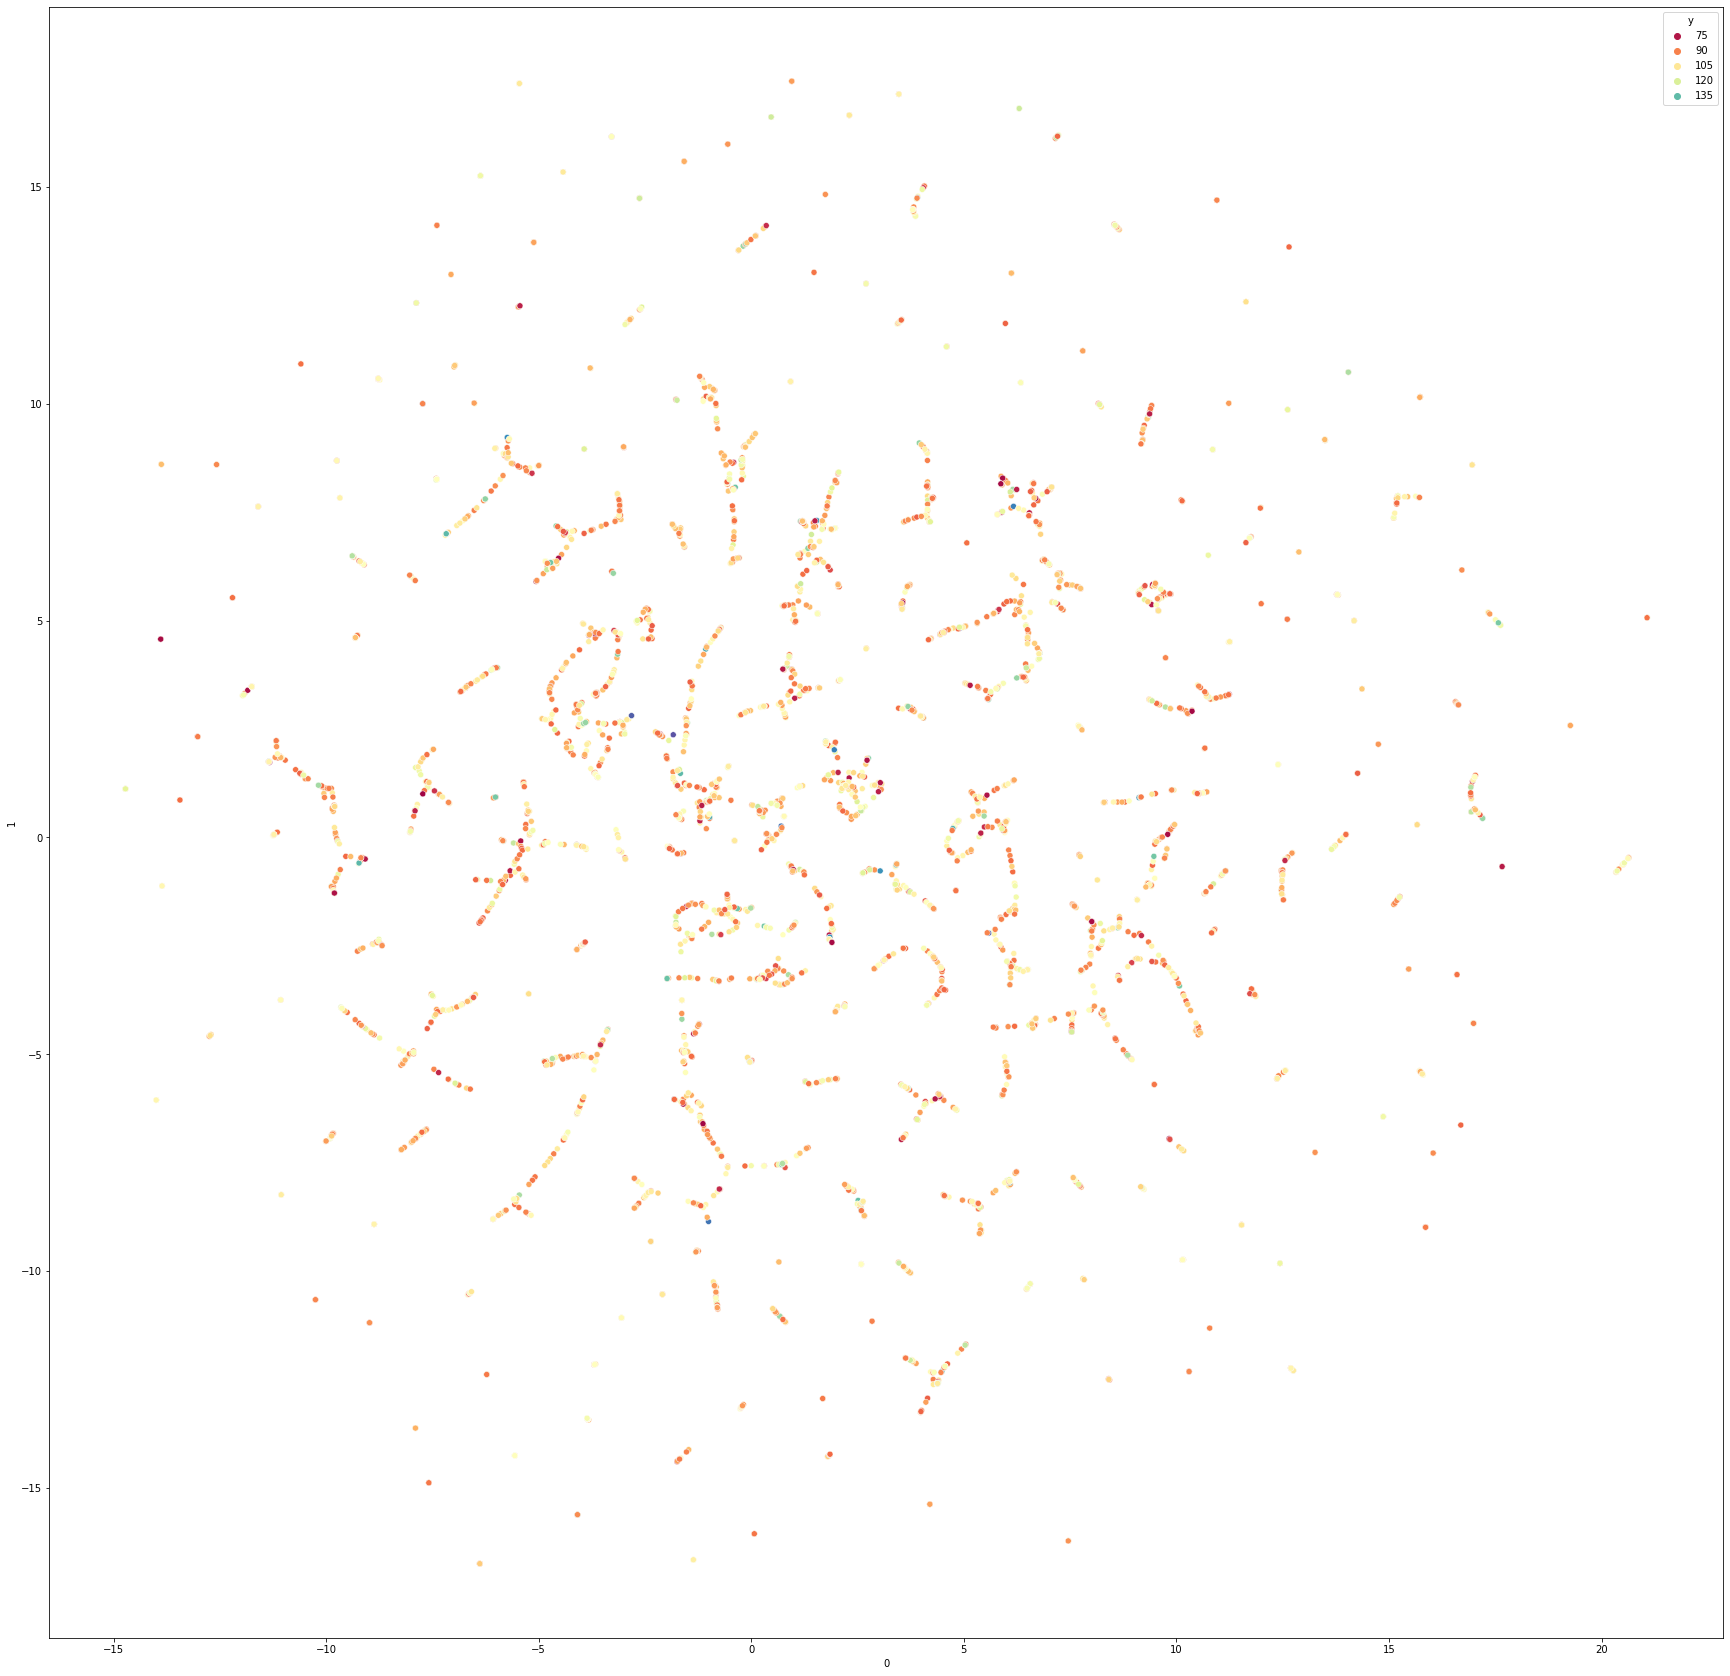

In [110]:
plot_UMAP(UMAP_test(catencoded, 3, min_dist=0.1))